## 1. Import Library

In [1]:
import pandas as pd
import numpy as np
import re, string, pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/faishalfarizhidayatullah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/faishalfarizhidayatullah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/faishalfarizhidayatullah/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## 2. Load Data

In [1]:
import sys
print(sys.executable)

/opt/homebrew/Cellar/jupyterlab/4.4.7/libexec/bin/python


In [2]:
df = pd.read_csv("Phishing_Email.csv")   # ganti sesuai path dataset
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (18650, 3)
   Unnamed: 0                                         Email Text  \
0           0  re : 6 . 1100 , disc : uniformitarianism , re ...   
1           1  the other side of * galicismos * * galicismo *...   
2           2  re : equistar deal tickets are you still avail...   
3           3  \nHello I am your hot lil horny toy.\n    I am...   
4           4  software at incredibly low prices ( 86 % lower...   

       Email Type  
0      Safe Email  
1      Safe Email  
2      Safe Email  
3  Phishing Email  
4  Phishing Email  


## 3. Data Ratio

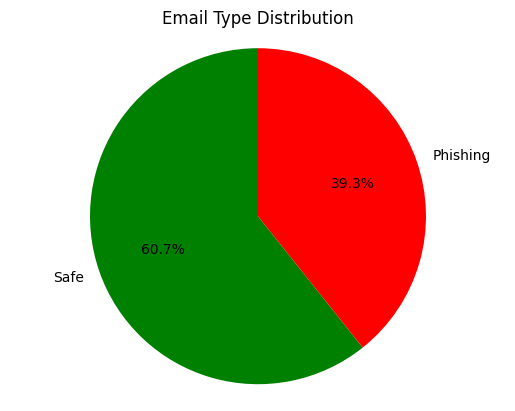

In [43]:
count = df["Email Type"].count()

safe_ratio = df["Email Type"].value_counts()["Safe Email"] / count
phishing_ratio = df["Email Type"].value_counts()["Phishing Email"] / count

plt.pie([safe_ratio, phishing_ratio], 
        labels=['Safe', 'Phishing'], 
        colors=["green", "red"],
        autopct='%1.1f%%', 
        startangle=90)
plt.title('Email Type Distribution')
plt.axis('equal')
plt.show()

## 4. Remove Missing Values

In [44]:
df.isnull().sum()

Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

In [45]:
df = df.dropna()

In [46]:
df.isnull().sum()

Unnamed: 0    0
Email Text    0
Email Type    0
dtype: int64

## 5. Remove Index Column

In [47]:
# Remove index column
df = df.drop("Unnamed: 0", axis=1)

## 6. Preprocessing

1. Case folding all text: Conversion to lowercase,
2. Data cleaning by removing unnecessary characters
3. Stopwords removal
4. Stemming: reduced words to their root forms
5. Feature Extraction: TF-IDF
6. Label Encoding

In [48]:
from nltk.tokenize import word_tokenize

stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))

def clean_text(text):
    # case folding
    text = text.lower()

    # remove email headers & metadata
    text = re.sub(r'^.*?subject:\s*', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\b(?:from|to|cc|bcc|sent|date):.*?\n', ' ', text, flags=re.IGNORECASE)

    # remove html tags
    text = re.sub(r"<.*?>", " ", text)
    # remove urls
    text = re.sub(r"(www\.[^\s]+|https?://[^\s]+|http?://[^\s]+)", " ", text)
    # remove newline
    text = text.replace("\n", " ")
    # remove non-alphanumeric
    text = re.sub("[^0-9a-zA-Z]+", " ", text)
    # remove numbers
    text = re.sub(r"\d+", "", text)
    # remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    # tokenizing
    tokens = word_tokenize(text)

    # stopwords removal
    tokens = [word for word in tokens if word not in stop_words]

    # stemming
    stemmed = [stemmer.stem(word) for word in tokens]

    return " ".join(stemmed)

# Pemakaian
df.dropna(subset=["Email Text", "Email Type"], inplace=True)
df["Clean_Text"] = df["Email Text"].apply(clean_text)

# Label Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["Label"] = le.fit_transform(df["Email Type"])  # Safe Email=1, Phishing Email=0

In [49]:
df.to_csv('Preprocessed_Phishing_Email.csv', index=False)

In [50]:
data_clean = pd.read_csv("Preprocessed_Phishing_Email.csv")
data_clean.head(5)

,Email Text,Email Type,Clean_Text,Label
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarian sex lang dick hudson obser...,1
1,the other side of * galicismos * * galicismo *...,Safe Email,side galicismo galicismo spanish term name imp...,1
2,re : equistar deal tickets are you still avail...,Safe Email,equistar deal ticket still avail assist robert...,1
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,hello hot lil horni toy one dream open mind pe...,0
4,software at incredibly low prices ( 86 % lower...,Phishing Email,softwar incred low price lower draperi sevente...,0


## 7. Model: Stacking (SVM + XGBoost → Logistic Regression)

In [51]:
X = df["Clean_Text"]
y = df["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [52]:
# tfidf = TfidfVectorizer(max_features=5000)
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
# svm = SVC(kernel="linear", probability=True, random_state=42)
svm = SVC(C=10, kernel="linear", probability=True, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
XGBClassifier(eval_metric="logloss", learning_rate=0.1, max_depth=6,
              n_estimators=500, subsample=0.8, colsample_bytree=0.8, random_state=42)
meta = LogisticRegression(max_iter=1000, random_state=42)

stack_model = StackingClassifier(
    estimators=[("svm", svm), ("xgb", xgb)],
    final_estimator=meta,
    cv=5
)

pipeline = Pipeline([
    ("tfidf", tfidf),
    ("stack", stack_model)
])

# Training
pipeline.fit(X_train, y_train)

/opt/homebrew/Cellar/jupyterlab/4.4.7/libexec/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [06:14:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Cellar/jupyterlab/4.4.7/libexec/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [06:19:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Cellar/jupyterlab/4.4.7/libexec/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [06:19:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Cellar/jupyterlab/4.4.7/libexec/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [06:19:49] WARNING: /Users/runner/w

,steps,"[('tfidf', ...), ('stack', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


## 8. Evaluasi Model

Classification Report:
                 precision    recall  f1-score   support

Phishing Email       0.96      0.97      0.96      1462
    Safe Email       0.98      0.97      0.98      2265

      accuracy                           0.97      3727
     macro avg       0.97      0.97      0.97      3727
  weighted avg       0.97      0.97      0.97      3727

Accuracy: 0.9710222699221894
Precision: 0.9799732977303071
Recall: 0.9721854304635762
F1-Score: 0.976063829787234


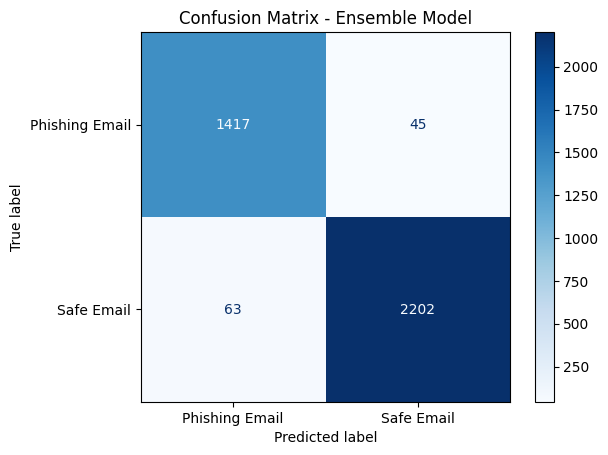

In [54]:
y_pred = pipeline.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Ensemble Model")
plt.show()

## 9. Visualisasi Tambahan

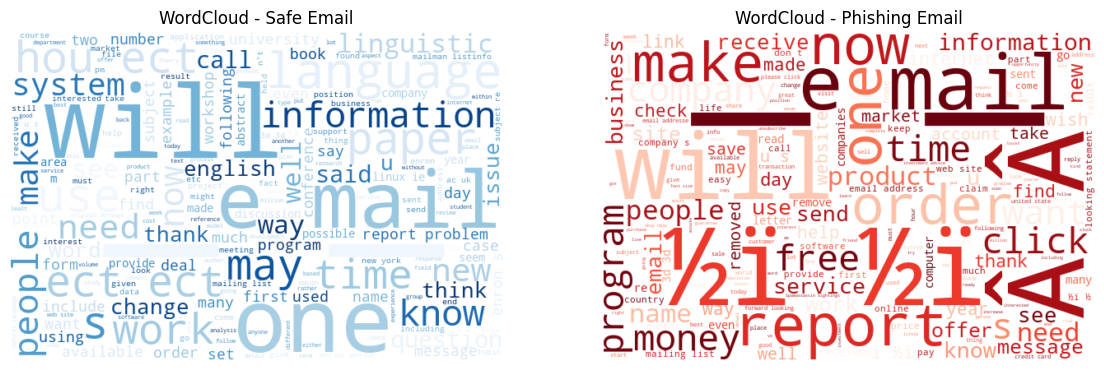

/var/folders/gv/0ps3ktdn6m1gtvgm5pcgdyg40000gn/T/ipykernel_5241/2888694464.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(scores.keys()), y=list(scores.values()), palette="viridis")


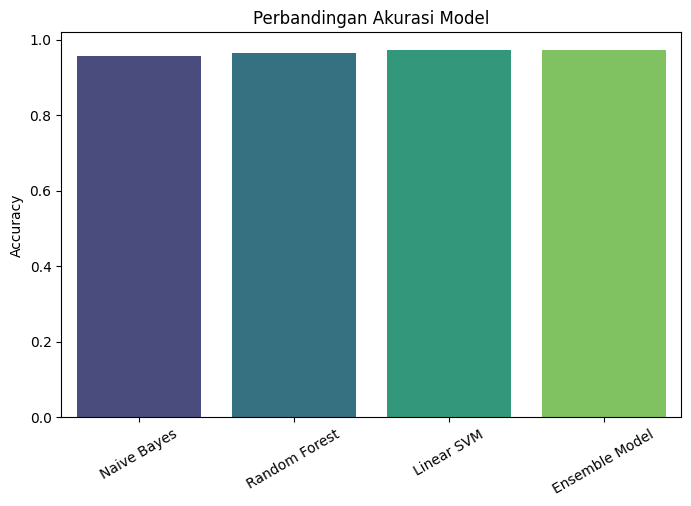

{'Naive Bayes': 0.9576066541454252, 'Random Forest': 0.9645827743493426, 'Linear SVM': 0.9710222699221894, 'Ensemble Model': 0.9710222699221894}


In [55]:
# (b) WordCloud Safe vs Phishing
from wordcloud import WordCloud
safe_text = " ".join(df[df["Email Type"]=="Safe Email"]["Email Text"].dropna().tolist())
phish_text = " ".join(df[df["Email Type"]=="Phishing Email"]["Email Text"].dropna().tolist())

wc_safe = WordCloud(width=600, height=400, background_color="white", colormap="Blues").generate(safe_text)
wc_phish = WordCloud(width=600, height=400, background_color="white", colormap="Reds").generate(phish_text)

fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[0].imshow(wc_safe, interpolation="bilinear"); ax[0].set_title("WordCloud - Safe Email"); ax[0].axis("off")
ax[1].imshow(wc_phish, interpolation="bilinear"); ax[1].set_title("WordCloud - Phishing Email"); ax[1].axis("off")
plt.show()

# (c) Perbandingan akurasi model lain
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

models = {
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Linear SVM": LinearSVC(random_state=42)
}

scores = {}
for name, clf in models.items():
    clf.fit(tfidf.fit_transform(X_train), y_train)
    y_pred_tmp = clf.predict(tfidf.transform(X_test))
    scores[name] = accuracy_score(y_test, y_pred_tmp)

scores["Ensemble Model"] = accuracy_score(y_test, y_pred)

plt.figure(figsize=(8,5))
sns.barplot(x=list(scores.keys()), y=list(scores.values()), palette="viridis")
plt.title("Perbandingan Akurasi Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=30)
plt.show()

print(scores)


In [58]:
with open("phishing_model.pkl", "wb") as f:
    pickle.dump(pipeline, f)

print("✅ Model disimpan sebagai phishing_model.pkl")

✅ Model disimpan sebagai phishing_model.pkl
